In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
# read a CSV into a dataframe (adjust filename as needed)
events_filename = './data/event.csv'  # or provide a full path

if not os.path.exists(events_filename):
    csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"{events_filename!r} not found and no CSV files in the current directory.")
    filename = csv_files[0]
    print(f"No file named 'data.csv' found. Using first CSV in cwd: {filename}")

events = pd.read_csv(events_filename)
print(f"Loaded {len(events)} rows and {len(events.columns)} columns from {events_filename}")
events.head()

Loaded 107738 rows and 14 columns from ./data/event.csv


/var/folders/_b/sl_t4k5539781f29qf723b080000gn/T/ipykernel_50549/2221732598.py:11: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv(events_filename)


,type,inPlay,isStrike,isBall,pitcherName,catcherName,batterName,pitchCode,pitchType,velocity,coordX,coordY,runners,PAId
0,PITCH,False,False,True,徐若熙,蔣少宏,陳晨威,B,FF,145,71.11,-91.43,[],NaN
1,PITCH,True,True,False,徐若熙,蔣少宏,陳晨威,H,FF,147,54.86,42.67,"[{'type': 'PA', 'runnerName': '陳晨威', 'isOut': ...",NaN
2,PITCH,False,True,False,徐若熙,蔣少宏,林立,F,FF,145,54.86,22.35,[],NaN
3,PITCH,False,True,False,徐若熙,蔣少宏,林立,SW,SL,135,-2.03,-56.89,[],NaN
4,PITCH,False,False,True,徐若熙,蔣少宏,林立,B,SL,139,-34.54,-144.25,[],NaN


In [3]:
events['coordX'] = events['coordX'] * 0.5 * 0.3937  # convert cm to inches and scale X
events['coordY'] = events['coordY'] * 0.5 * 0.3937  # convert cm to inches and scale Y

In [4]:
### filter out non-PITCH type
test_events = events[(events['pitcherName'] == '古林睿煬') & (events['type'] == 'PITCH')]

In [5]:
print(test_events.shape)
test_events.head()

(1922, 14)


,type,inPlay,isStrike,isBall,pitcherName,catcherName,batterName,pitchCode,pitchType,velocity,coordX,coordY,runners,PAId
7330,PITCH,False,True,False,古林睿煬,陳重羽,岳政華,F,FF,145,-2.710624,4.023614,[],NaN
7331,PITCH,False,False,True,古林睿煬,陳重羽,岳政華,B,FF,144,-12.122023,-10.720451,[],NaN
7332,PITCH,True,True,False,古林睿煬,陳重羽,岳政華,H,FF,142,-4.712589,-7.588567,"[{'type': 'PA', 'runnerName': '岳政華', 'isOut': ...",NaN
7333,PITCH,False,True,False,古林睿煬,陳重羽,岳東華,FOUL_BUNT,FF,138,0.027559,13.580681,[],NaN
7334,PITCH,False,False,True,古林睿煬,陳重羽,岳東華,B,FF,139,-11.222418,-20.620037,[],NaN


In [6]:
_swing_tokens = {'SW', 'F', 'FT', 'FOUL_BUNT', 'TRY_BUNT', 'BUNT', 'H'}
called_strikes = test_events[test_events['pitchCode']=='S']
swing_strikes = test_events[test_events['pitchCode'].isin(_swing_tokens)]
called_balls = test_events[test_events['pitchCode']=='B']

In [7]:
# coordXs = test_events['coordX'].to_numpy() * 0.5 * 0.3937  # convert cm to inches and scale X
# coordYs = test_events['coordY'].to_numpy() * 0.5 * 0.3937  # convert cm to inches and scale Y

called_strikes_X = called_strikes['coordX'].to_numpy()
called_strikes_Y = called_strikes['coordY'].to_numpy()
swing_strikes_X = swing_strikes['coordX'].to_numpy()
swing_strikes_Y = swing_strikes['coordY'].to_numpy()
called_balls_X = called_balls['coordX'].to_numpy()
called_balls_Y = called_balls['coordY'].to_numpy()

In [8]:
strike_zone_width = 17.0 + 2.9 # plate width + margin (one ball width on each side)
strike_zone_height = strike_zone_width * 1.2
strike_zone = [-strike_zone_width/2, strike_zone_width/2, -strike_zone_height/2, strike_zone_height/2] # left, right, bottom, top

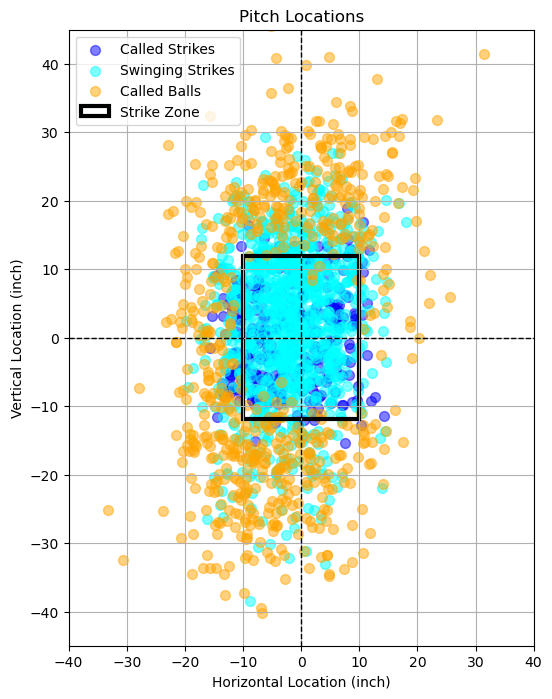

In [9]:
plt.figure(figsize=(6,8))
plt.scatter(called_strikes_X, called_strikes_Y, color='blue', label='Called Strikes', alpha=0.5, s=50)
plt.scatter(swing_strikes_X, swing_strikes_Y, color='cyan', label='Swinging Strikes', alpha=0.5, s=50)
plt.scatter(called_balls_X, called_balls_Y, color='orange', label='Called Balls', alpha=0.5, s=50)
plt.xlim(-40, 40)
plt.ylim(-45, 45)
plt.xlabel('Horizontal Location (inch)')
plt.ylabel('Vertical Location (inch)')
plt.title('Pitch Locations')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.gca().add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                                  linewidth=3, edgecolor='k', facecolor='none', linestyle='-', label='Strike Zone'))
plt.legend()
plt.grid()
plt.show()  

In [10]:
_fastball_tokens = {'FF', 'SI', 'FC'} # four-seam, sinker, cutter
_offspeed_tokens = {'CH', 'FO', 'FS', 'KN', 'EP'} # changeup, forkball, split-finger, knuckleball
_breaking_tokens = {'CU', 'SL'} # curveball, slider
fastballs = test_events[test_events['pitchType'].isin(_fastball_tokens)]
offspeeds = test_events[test_events['pitchType'].isin(_offspeed_tokens)]
breakings = test_events[test_events['pitchType'].isin(_breaking_tokens)]

Text(0.5, 1.0, 'Pitch Velocity Distribution')

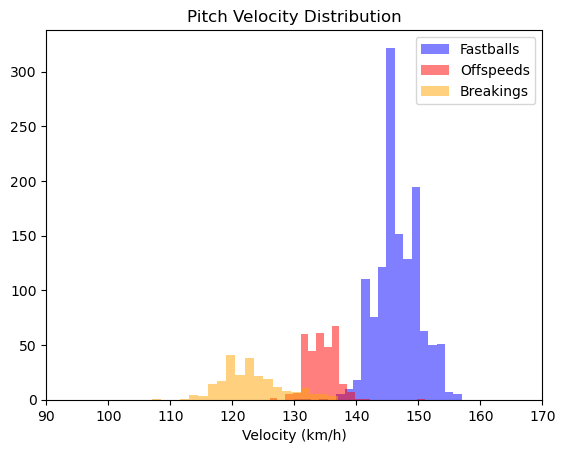

In [11]:
plt.hist(fastballs['velocity'].to_numpy(dtype=float), bins=20, alpha=0.5, label='Fastballs', color='blue')
plt.hist(offspeeds['velocity'].to_numpy(dtype=float), bins=20, alpha=0.5, label='Offspeeds', color='red')
plt.hist(breakings['velocity'].to_numpy(dtype=float), bins=20, alpha=0.5, label='Breakings', color='orange')
plt.xlabel('Velocity (km/h)')
plt.xlim(90, 170)
plt.legend()
plt.title('Pitch Velocity Distribution')



In [12]:
fastballs_X = fastballs['coordX'].to_numpy()
fastballs_Y = fastballs['coordY'].to_numpy()
offspeeds_X = offspeeds['coordX'].to_numpy()
offspeeds_Y = offspeeds['coordY'].to_numpy()
breakings_X = breakings['coordX'].to_numpy()
breakings_Y = breakings['coordY'].to_numpy()

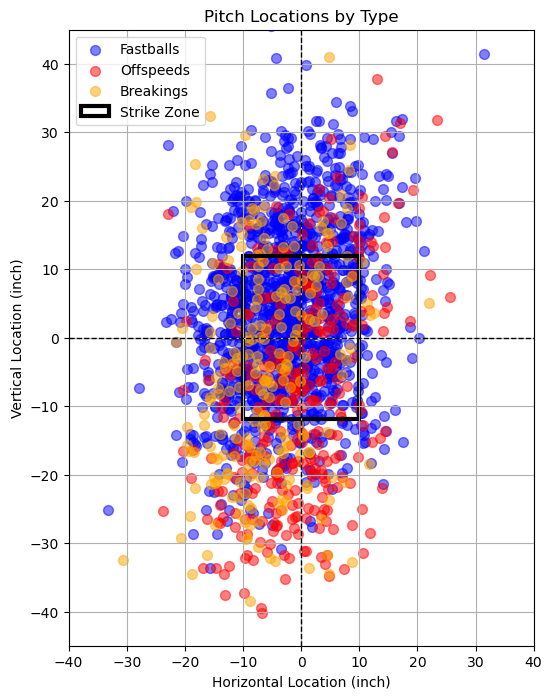

In [13]:
plt.figure(figsize=(6,8))
plt.scatter(fastballs_X, fastballs_Y, color='blue', label='Fastballs', alpha=0.5, s=50)
plt.scatter(offspeeds_X, offspeeds_Y, color='red', label='Offspeeds', alpha=0.5, s=50)
plt.scatter(breakings_X, breakings_Y, color='orange', label='Breakings', alpha=0.5, s=50)
plt.xlim(-40, 40)
plt.ylim(-45, 45)
plt.xlabel('Horizontal Location (inch)')
plt.ylabel('Vertical Location (inch)')
plt.title('Pitch Locations by Type')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.gca().add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                                  linewidth=3, edgecolor='k', facecolor='none', linestyle='-', label='Strike Zone'))
plt.legend()
plt.grid()
plt.show()